## 1. Prepare data and voxelMorph code



In [1]:
import voxelmorph2d as vm2d
import voxelmorph3d as vm3d

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.transform import resize
from skimage.filters import threshold_otsu
import multiprocessing as mp
from tqdm import tqdm
import gc
import time
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable

use_gpu = torch.cuda.is_available()

In [2]:
from skimage.color import rgb2gray

In [3]:
import os
import cv2

In [4]:
import importlib
importlib.reload(vm2d)

<module 'voxelmorph2d' from '/Users/nastya/Documents/ucu/thesis/voxelmorph/voxelmorph2d.py'>

In [5]:
from PIL import Image

## 2. Preparing GANs

In [ ]:
# def read_images_from_folder(folder_path):
#     images = []
#     for filename in sorted(os.listdir(folder_path)):
#         img_path = os.path.join(folder_path, filename)
#         if os.path.isfile(img_path):
#             img = Image.open(img_path)
#             img_array = np.array(img)
#             images.append(img_array)
#     return images

In [ ]:
# source_images = read_images_from_folder('/content/triangles_and_circles/source_images')
# target_images = read_images_from_folder('/content/triangles_and_circles/target_images')

In [ ]:
# pairs = list(zip(target_images, source_images))

In [ ]:
# train_ratio = 0.6
# validation_ratio = 0.2
# test_ratio = 0.2

# train_set, remaining_set = train_test_split(pairs, test_size=(validation_ratio + test_ratio), random_state=42)
# validation_set, test_set = train_test_split(remaining_set, test_size=test_ratio / (validation_ratio + test_ratio), random_state=42)

In [6]:
import pickle

# with open('/content/train_triangles.pkl', "wb") as f:
#     pickle.dump(train_set, f)

# with open('/content/val_triangles.pkl', "wb") as f:
#     pickle.dump(validation_set, f)

# with open('/content/test_triangles.pkl', "wb") as f:
#     pickle.dump(test_set, f)

with open('/Users/nastya/Documents/ucu/thesis/data/triangles_split/test_triangles.pkl', "rb") as f:
    test_set = pickle.load(f)

# with open('/content/train_triangles.pkl', "rb") as f:
#     train_set = pickle.load(f)

# with open('/content/val_triangles.pkl', "rb") as f:
#     validation_set = pickle.load(f)

In [8]:
train_set = train_set + validation_set

In [7]:
class TrianglesDataset(data.Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        target_image = self.pairs[idx][0]
        source_image = self.pairs[idx][1]

        target_image = (target_image > 127).view(np.uint8) * 255
        source_image = (source_image > 127).view(np.uint8) * 255

        target_image = torch.Tensor(target_image)
        source_image = torch.Tensor(source_image)

        return target_image, source_image

In [10]:
train_data = TrianglesDataset(train_set)

In [11]:
batch_size = 32
training_generator = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [8]:
class VoxelMorph():
    """
    VoxelMorph Class is a higher level interface for both 2D and 3D
    Voxelmorph classes. It makes training easier and is scalable.
    """

    def __init__(self, input_dims, is_2d=False, use_gpu=False):
        self.dims = input_dims
        if is_2d:
            self.vm = vm2d
            self.voxelmorph = vm2d.VoxelMorph2d(input_dims[0] * 2, use_gpu)
        else:
            self.vm = vm3d
            self.voxelmorph = vm3d.VoxelMorph3d(input_dims[0] * 2, use_gpu)
        self.optimizer = optim.SGD(self.voxelmorph.parameters(), lr=1e-4, momentum=0.99)
        self.params = {'batch_size': 3,
                       'shuffle': True,
                       'num_workers': 6,
                       'worker_init_fn': np.random.seed(42)
                       }
        self.device = torch.device("cuda:0" if use_gpu else "cpu")

    def check_dims(self, x):
        try:
            if x.shape[1:] == self.dims:
                return
            else:
                raise TypeError
        except TypeError as e:
            print("Invalid Dimension Error. The supposed dimension is ",
                  self.dims, "But the dimension of the input is ", x.shape[1:])

    def forward(self, x):
        self.check_dims(x)
        return voxelmorph(x)

    def calculate_loss(self, y, ytrue, n=9, lamda=0.01, is_training=True):
        loss = self.vm.vox_morph_loss(y, ytrue, n, lamda)
        return loss

    def train_model(self, batch_moving, batch_fixed, n=9, lamda=0.01, return_metric_score=True):
        self.optimizer.zero_grad()
        batch_fixed, batch_moving = batch_fixed.to(self.device), batch_moving.to(self.device)
        registered_image, _ = self.voxelmorph(batch_moving, batch_fixed)
        print(batch_fixed.shape)
        train_loss = self.calculate_loss(registered_image, batch_fixed, n, lamda)
        train_loss.backward()
        self.optimizer.step()
        if return_metric_score:
            train_dice_score = self.vm.dice_score(registered_image, batch_fixed)
            return train_loss, train_dice_score
        return train_loss

    def get_test_loss(self, batch_moving, batch_fixed, n=9, lamda=0.01):
        with torch.set_grad_enabled(False):
            registered_image, _ = self.voxelmorph(batch_moving, batch_fixed)
            val_loss = self.vm.vox_morph_loss(registered_image, batch_fixed, n, lamda)
            val_dice_score = self.vm.dice_score(registered_image, batch_fixed)
            return val_loss, val_dice_score

## 3. GANs

In [9]:
def add_conv_stage(dim_in, dim_out, kernel_size = 4, stride = 2, padding = 1, bias = False):
  return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.2, inplace=True)
  )

  ## Define discriminator
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            add_conv_stage(64, 128),
            add_conv_stage(128, 256),
            add_conv_stage(256, 512),
            nn.Conv2d(512, 1, 4,2,1, bias = False),
            nn.LeakyReLU(0.2),
            nn.Sigmoid()
        )

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        return self.layers(input)


In [10]:
## Generator
vm = VoxelMorph((1, 128, 128), is_2d=True,  use_gpu=use_gpu)

generator = vm.voxelmorph


In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
D = discriminator()
G = generator

lr_g = 2e-4
lr_d = 1e-4

D_losses = []
G_losses = []
G_losses_total = []

BCELoss = nn.BCELoss()
MSELoss = nn.MSELoss()
KLDiveLoss = nn.KLDivLoss()

SmoothingLoss = vm2d.smooothing_loss

G_optimizer = optim.Adam(G.parameters(), lr=lr_g, betas=(.5, 0.999))
# D_optimizer = optim.Adam(D.parameters(), lr=lr_d, betas=(.5, 0.999))
D_optimizer = optim.SGD(D.parameters(), lr=lr_d)

if use_gpu:
    G = G.cuda()
    D = D.cuda()
D.apply(weights_init)
G.apply(weights_init)

VoxelMorph2d(
  (unet): UNet(
    (conv_encode1): Sequential(
      (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (conv_maxpool2): MaxPool2d(kernel_size=2, stride=2,

In [17]:
epochs = 80
train_interval = 10
for epoch in tqdm(range(epochs)):

    for batch_moving, batch_fixed in training_generator:

        mini_batch = batch_moving.shape[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        if use_gpu:
            y_real_ = y_real_.cuda()
            y_fake_ = y_fake_.cuda()
            batch_moving = batch_moving.cuda()
            batch_fixed = batch_fixed.cuda()

        batch_fixed = batch_fixed.unsqueeze(3)
        batch_moving = batch_moving.unsqueeze(3)

        batch_fixed_reorder = batch_fixed.permute(0, 3, 1, 2)
        batch_moving_reorder = batch_moving.permute(0, 3, 1, 2)

        # Train discriminator D
        D.zero_grad()
        # D_real = D(batch_moving_reorder).view(-1)

        D_real = torch.mean(D(batch_moving_reorder), dim=(1, 2, 3))

        D_real_loss = BCELoss(D_real, Variable(y_real_))
        D_real_loss.backward()

        with torch.no_grad():
            dat_fake, _ = G(batch_moving, batch_fixed)
        dat_fake_reorder = dat_fake.permute(0, 3, 1, 2)

        # D_fake = D(dat_fake_reorder).view(-1)
        D_fake = torch.mean(D(dat_fake_reorder), dim=(1, 2, 3))

        D_fake_loss = BCELoss(D_fake, Variable(y_fake_))
        D_fake_loss.backward()

        D_optimizer.step()
        D_train_loss = D_real_loss + D_fake_loss
        D_losses.append(D_train_loss.data.item())

        # Train generator G
        for iter in range(train_interval):

            G.zero_grad()
            dat_fake, _ = G(batch_moving, batch_fixed)
            dat_fake_reorder = dat_fake.permute(0, 3, 1, 2)

            with torch.no_grad():
            #   D_fake = D(dat_fake_reorder).view(-1)
                D_fake = torch.mean(D(dat_fake_reorder), dim=(1, 2, 3))
            G_train_loss = BCELoss(D_fake, Variable(y_real_))
            G_train_loss_total = G_train_loss + 1e-3*MSELoss(dat_fake, batch_fixed)+1e-3*SmoothingLoss(dat_fake)

            G_train_loss_total.backward()
            G_optimizer.step()
            G_losses.append(G_train_loss.data.item())
            G_losses_total.append(G_train_loss_total.data.item())

    print('[%d/%d] - loss_d: %.3f, loss_g: %.3f, loss_g_total: %.3f' % ((epoch + 1), epochs,
                                                    torch.mean(torch.FloatTensor(D_losses)),
                                                    torch.mean(torch.FloatTensor(G_losses)),
                                                    torch.mean(torch.FloatTensor(G_losses_total))))


  1%|▏         | 1/80 [00:56<1:14:08, 56.31s/it]

[1/80] - loss_d: 1.442, loss_g: 0.500, loss_g_total: 10.239


  2%|▎         | 2/80 [01:52<1:13:20, 56.42s/it]

[2/80] - loss_d: 1.433, loss_g: 0.519, loss_g_total: 9.886


  4%|▍         | 3/80 [02:49<1:12:35, 56.57s/it]

[3/80] - loss_d: 1.426, loss_g: 0.535, loss_g_total: 9.699


  5%|▌         | 4/80 [03:46<1:11:50, 56.71s/it]

[4/80] - loss_d: 1.420, loss_g: 0.548, loss_g_total: 9.572


  6%|▋         | 5/80 [04:43<1:10:56, 56.75s/it]

[5/80] - loss_d: 1.416, loss_g: 0.559, loss_g_total: 9.467


  8%|▊         | 6/80 [05:40<1:10:02, 56.80s/it]

[6/80] - loss_d: 1.412, loss_g: 0.569, loss_g_total: 9.380


  9%|▉         | 7/80 [06:37<1:09:08, 56.83s/it]

[7/80] - loss_d: 1.409, loss_g: 0.578, loss_g_total: 9.308


 10%|█         | 8/80 [07:34<1:08:13, 56.85s/it]

[8/80] - loss_d: 1.407, loss_g: 0.585, loss_g_total: 9.240


 11%|█▏        | 9/80 [08:30<1:07:16, 56.85s/it]

[9/80] - loss_d: 1.404, loss_g: 0.592, loss_g_total: 9.176


 12%|█▎        | 10/80 [09:27<1:06:19, 56.85s/it]

[10/80] - loss_d: 1.402, loss_g: 0.597, loss_g_total: 9.117


 14%|█▍        | 11/80 [10:24<1:05:22, 56.85s/it]

[11/80] - loss_d: 1.401, loss_g: 0.603, loss_g_total: 9.063


 15%|█▌        | 12/80 [11:21<1:04:27, 56.87s/it]

[12/80] - loss_d: 1.399, loss_g: 0.607, loss_g_total: 9.013


 16%|█▋        | 13/80 [12:18<1:03:30, 56.87s/it]

[13/80] - loss_d: 1.398, loss_g: 0.611, loss_g_total: 8.964


 18%|█▊        | 14/80 [13:15<1:02:31, 56.85s/it]

[14/80] - loss_d: 1.397, loss_g: 0.615, loss_g_total: 8.916


 19%|█▉        | 15/80 [14:11<1:01:35, 56.85s/it]

[15/80] - loss_d: 1.395, loss_g: 0.619, loss_g_total: 8.870


 20%|██        | 16/80 [15:08<1:00:38, 56.85s/it]

[16/80] - loss_d: 1.394, loss_g: 0.622, loss_g_total: 8.822


 21%|██▏       | 17/80 [16:05<59:40, 56.84s/it]  

[17/80] - loss_d: 1.393, loss_g: 0.625, loss_g_total: 8.779


 22%|██▎       | 18/80 [17:02<58:44, 56.85s/it]

[18/80] - loss_d: 1.392, loss_g: 0.628, loss_g_total: 8.737


 24%|██▍       | 19/80 [17:59<57:46, 56.83s/it]

[19/80] - loss_d: 1.391, loss_g: 0.630, loss_g_total: 8.695


 25%|██▌       | 20/80 [18:56<56:48, 56.82s/it]

[20/80] - loss_d: 1.391, loss_g: 0.632, loss_g_total: 8.654


 26%|██▋       | 21/80 [19:52<55:51, 56.80s/it]

[21/80] - loss_d: 1.390, loss_g: 0.635, loss_g_total: 8.617


 28%|██▊       | 22/80 [20:49<54:55, 56.81s/it]

[22/80] - loss_d: 1.389, loss_g: 0.637, loss_g_total: 8.579


 29%|██▉       | 23/80 [21:46<53:58, 56.82s/it]

[23/80] - loss_d: 1.388, loss_g: 0.638, loss_g_total: 8.540


 30%|███       | 24/80 [22:43<53:01, 56.82s/it]

[24/80] - loss_d: 1.388, loss_g: 0.640, loss_g_total: 8.504


 31%|███▏      | 25/80 [23:40<52:05, 56.84s/it]

[25/80] - loss_d: 1.387, loss_g: 0.642, loss_g_total: 8.469


 32%|███▎      | 26/80 [24:36<51:08, 56.82s/it]

[26/80] - loss_d: 1.386, loss_g: 0.643, loss_g_total: 8.434


 34%|███▍      | 27/80 [25:33<50:11, 56.83s/it]

[27/80] - loss_d: 1.386, loss_g: 0.644, loss_g_total: 8.400


 35%|███▌      | 28/80 [26:30<49:13, 56.80s/it]

[28/80] - loss_d: 1.385, loss_g: 0.646, loss_g_total: 8.366


 36%|███▋      | 29/80 [27:27<48:16, 56.80s/it]

[29/80] - loss_d: 1.384, loss_g: 0.647, loss_g_total: 8.334


 38%|███▊      | 30/80 [28:24<47:20, 56.82s/it]

[30/80] - loss_d: 1.384, loss_g: 0.648, loss_g_total: 8.302


 39%|███▉      | 31/80 [29:21<46:24, 56.83s/it]

[31/80] - loss_d: 1.383, loss_g: 0.649, loss_g_total: 8.268


 40%|████      | 32/80 [30:17<45:27, 56.83s/it]

[32/80] - loss_d: 1.382, loss_g: 0.650, loss_g_total: 8.236


 41%|████▏     | 33/80 [31:14<44:30, 56.82s/it]

[33/80] - loss_d: 1.382, loss_g: 0.651, loss_g_total: 8.206


 42%|████▎     | 34/80 [32:11<43:33, 56.81s/it]

[34/80] - loss_d: 1.381, loss_g: 0.652, loss_g_total: 8.175


 44%|████▍     | 35/80 [33:08<42:37, 56.82s/it]

[35/80] - loss_d: 1.381, loss_g: 0.653, loss_g_total: 8.144


 45%|████▌     | 36/80 [34:05<41:38, 56.79s/it]

[36/80] - loss_d: 1.380, loss_g: 0.654, loss_g_total: 8.116


 46%|████▋     | 37/80 [35:01<40:43, 56.81s/it]

[37/80] - loss_d: 1.380, loss_g: 0.654, loss_g_total: 8.088


 48%|████▊     | 38/80 [35:58<39:45, 56.80s/it]

[38/80] - loss_d: 1.379, loss_g: 0.655, loss_g_total: 8.058


 49%|████▉     | 39/80 [36:55<38:49, 56.81s/it]

[39/80] - loss_d: 1.379, loss_g: 0.656, loss_g_total: 8.032


 50%|█████     | 40/80 [37:52<37:52, 56.81s/it]

[40/80] - loss_d: 1.379, loss_g: 0.656, loss_g_total: 8.004


 51%|█████▏    | 41/80 [38:49<36:55, 56.81s/it]

[41/80] - loss_d: 1.378, loss_g: 0.657, loss_g_total: 7.977


 52%|█████▎    | 42/80 [39:45<35:58, 56.80s/it]

[42/80] - loss_d: 1.378, loss_g: 0.657, loss_g_total: 7.950


 54%|█████▍    | 43/80 [40:42<35:01, 56.79s/it]

[43/80] - loss_d: 1.377, loss_g: 0.658, loss_g_total: 7.923


 55%|█████▌    | 44/80 [41:39<34:04, 56.78s/it]

[44/80] - loss_d: 1.377, loss_g: 0.659, loss_g_total: 7.896


 56%|█████▋    | 45/80 [42:36<33:07, 56.78s/it]

[45/80] - loss_d: 1.376, loss_g: 0.659, loss_g_total: 7.870


 57%|█████▊    | 46/80 [43:33<32:10, 56.78s/it]

[46/80] - loss_d: 1.376, loss_g: 0.660, loss_g_total: 7.844


 59%|█████▉    | 47/80 [44:29<31:13, 56.78s/it]

[47/80] - loss_d: 1.375, loss_g: 0.660, loss_g_total: 7.820


 60%|██████    | 48/80 [45:26<30:17, 56.79s/it]

[48/80] - loss_d: 1.375, loss_g: 0.660, loss_g_total: 7.794


 61%|██████▏   | 49/80 [46:23<29:20, 56.78s/it]

[49/80] - loss_d: 1.375, loss_g: 0.661, loss_g_total: 7.769


 62%|██████▎   | 50/80 [47:20<28:23, 56.78s/it]

[50/80] - loss_d: 1.374, loss_g: 0.661, loss_g_total: 7.745


 64%|██████▍   | 51/80 [48:16<27:26, 56.78s/it]

[51/80] - loss_d: 1.374, loss_g: 0.662, loss_g_total: 7.722


 65%|██████▌   | 52/80 [49:13<26:30, 56.79s/it]

[52/80] - loss_d: 1.373, loss_g: 0.662, loss_g_total: 7.698


 66%|██████▋   | 53/80 [50:10<25:33, 56.80s/it]

[53/80] - loss_d: 1.373, loss_g: 0.663, loss_g_total: 7.676


 68%|██████▊   | 54/80 [51:07<24:36, 56.80s/it]

[54/80] - loss_d: 1.373, loss_g: 0.663, loss_g_total: 7.653


 69%|██████▉   | 55/80 [52:04<23:39, 56.78s/it]

[55/80] - loss_d: 1.372, loss_g: 0.663, loss_g_total: 7.629


 70%|███████   | 56/80 [53:00<22:42, 56.78s/it]

[56/80] - loss_d: 1.372, loss_g: 0.664, loss_g_total: 7.605


 71%|███████▏  | 57/80 [53:57<21:46, 56.79s/it]

[57/80] - loss_d: 1.371, loss_g: 0.664, loss_g_total: 7.584


 72%|███████▎  | 58/80 [54:54<20:49, 56.79s/it]

[58/80] - loss_d: 1.371, loss_g: 0.664, loss_g_total: 7.561


 74%|███████▍  | 59/80 [55:51<19:52, 56.80s/it]

[59/80] - loss_d: 1.371, loss_g: 0.665, loss_g_total: 7.539


 75%|███████▌  | 60/80 [56:48<18:55, 56.78s/it]

[60/80] - loss_d: 1.370, loss_g: 0.665, loss_g_total: 7.517


 76%|███████▋  | 61/80 [57:44<17:58, 56.79s/it]

[61/80] - loss_d: 1.370, loss_g: 0.665, loss_g_total: 7.496


 78%|███████▊  | 62/80 [58:41<17:02, 56.81s/it]

[62/80] - loss_d: 1.370, loss_g: 0.665, loss_g_total: 7.476


 79%|███████▉  | 63/80 [59:38<16:05, 56.81s/it]

[63/80] - loss_d: 1.369, loss_g: 0.666, loss_g_total: 7.455


 80%|████████  | 64/80 [1:00:35<15:08, 56.79s/it]

[64/80] - loss_d: 1.369, loss_g: 0.666, loss_g_total: 7.434


 81%|████████▏ | 65/80 [1:01:32<14:11, 56.78s/it]

[65/80] - loss_d: 1.368, loss_g: 0.666, loss_g_total: 7.413


 82%|████████▎ | 66/80 [1:02:28<13:14, 56.76s/it]

[66/80] - loss_d: 1.368, loss_g: 0.666, loss_g_total: 7.393


 84%|████████▍ | 67/80 [1:03:25<12:18, 56.77s/it]

[67/80] - loss_d: 1.368, loss_g: 0.667, loss_g_total: 7.374


 85%|████████▌ | 68/80 [1:04:22<11:21, 56.76s/it]

[68/80] - loss_d: 1.367, loss_g: 0.667, loss_g_total: 7.354


 86%|████████▋ | 69/80 [1:05:19<10:24, 56.77s/it]

[69/80] - loss_d: 1.367, loss_g: 0.667, loss_g_total: 7.334


 88%|████████▊ | 70/80 [1:06:15<09:27, 56.78s/it]

[70/80] - loss_d: 1.367, loss_g: 0.667, loss_g_total: 7.313


 89%|████████▉ | 71/80 [1:07:12<08:31, 56.79s/it]

[71/80] - loss_d: 1.366, loss_g: 0.667, loss_g_total: 7.293


 90%|█████████ | 72/80 [1:08:09<07:34, 56.79s/it]

[72/80] - loss_d: 1.366, loss_g: 0.668, loss_g_total: 7.273


 91%|█████████▏| 73/80 [1:09:06<06:37, 56.77s/it]

[73/80] - loss_d: 1.366, loss_g: 0.668, loss_g_total: 7.256


 92%|█████████▎| 74/80 [1:10:02<05:40, 56.75s/it]

[74/80] - loss_d: 1.365, loss_g: 0.668, loss_g_total: 7.237


 94%|█████████▍| 75/80 [1:10:59<04:43, 56.74s/it]

[75/80] - loss_d: 1.365, loss_g: 0.668, loss_g_total: 7.217


 95%|█████████▌| 76/80 [1:11:56<03:47, 56.76s/it]

[76/80] - loss_d: 1.365, loss_g: 0.668, loss_g_total: 7.198


 96%|█████████▋| 77/80 [1:12:53<02:50, 56.74s/it]

[77/80] - loss_d: 1.364, loss_g: 0.669, loss_g_total: 7.180


 98%|█████████▊| 78/80 [1:13:49<01:53, 56.73s/it]

[78/80] - loss_d: 1.364, loss_g: 0.669, loss_g_total: 7.163


 99%|█████████▉| 79/80 [1:14:46<00:56, 56.73s/it]

[79/80] - loss_d: 1.364, loss_g: 0.669, loss_g_total: 7.145


100%|██████████| 80/80 [1:15:43<00:00, 56.79s/it]

[80/80] - loss_d: 1.363, loss_g: 0.669, loss_g_total: 7.129


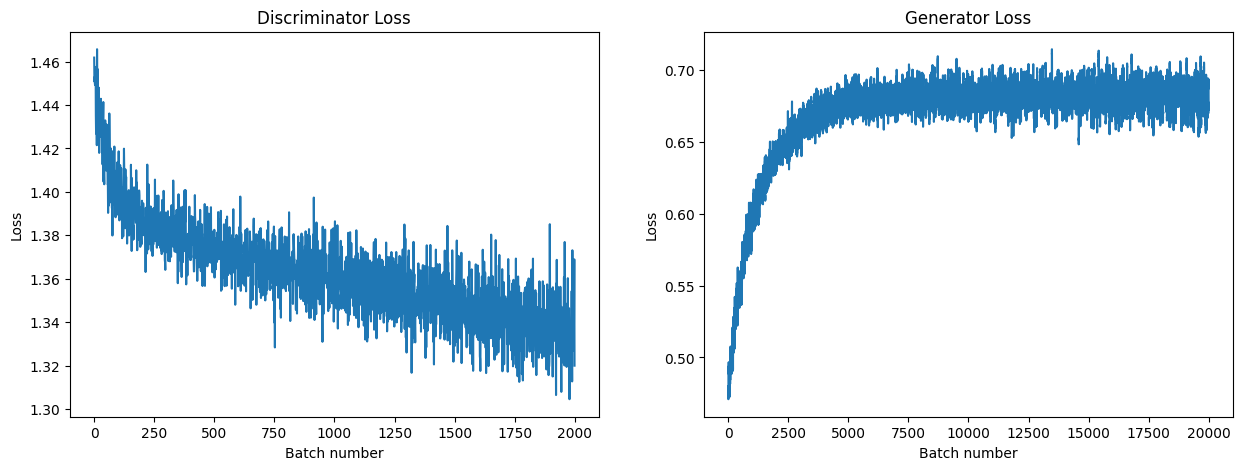

In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(D_losses)
plt.title("Discriminator Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(G_losses)
plt.title("Generator Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss");

In [19]:
D_losses_means = []
for i in range(0, len(D_losses), 32):
    chunk = D_losses[i:i+32]
    mean = sum(chunk) / len(chunk)
    D_losses_means.append(mean)

G_losses_means = []
for i in range(0, len(G_losses), 32):
    chunk = G_losses[i:i+32]
    mean = sum(chunk) / len(chunk)
    G_losses_means.append(mean)

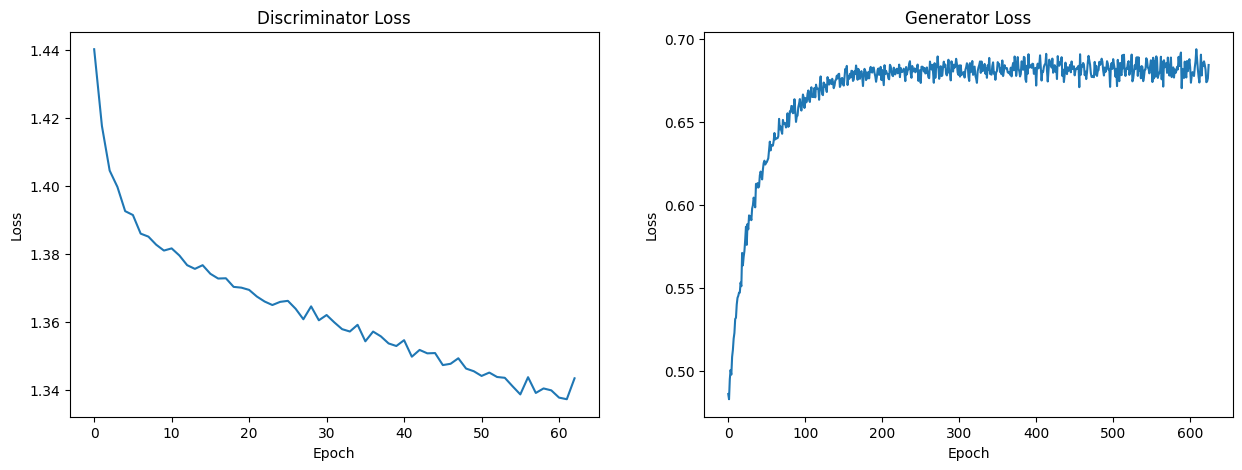

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(D_losses_means)
plt.title("Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(G_losses_means)
plt.title("Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss");

##Inference

In [21]:
torch.save(G.state_dict(), 'generator.pth')
torch.save(D.state_dict(), 'discriminator.pth')

In [22]:
# !zip -r /content/vm_gan_triangles_new.zip /content/vm_gan_triangles_new

  adding: content/vm_gan_triangles_new/ (stored 0%)
  adding: content/vm_gan_triangles_new/generator.pth (deflated 8%)
  adding: content/vm_gan_triangles_new/discriminator.pth (deflated 7%)


In [23]:
def read_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256))
    image = torch.Tensor(image)

    return image

In [ ]:
# validation_moving = [element[1] for element in validation_set]
# validation_fixed = [element[0] for element in validation_set]

In [24]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

start_time = time.time()

fixed = []
moving = []

registered = []
deforms = []

test_data = TrianglesDataset(test_set)
test_generator = data.DataLoader(test_data, batch_size=1, shuffle=False)

for batch_fixed, batch_moving in test_generator:

    fixed.append(batch_fixed)
    moving.append(batch_moving)

    batch_fixed = batch_fixed.unsqueeze(3).to(device)
    batch_moving = batch_moving.unsqueeze(3).to(device)

    val_registered, defor = G(batch_moving, batch_fixed)

    registered.append(val_registered)
    deforms.append(defor)

end_time = time.time() - start_time

print(end_time)

1.8837039470672607


Text(0.5, 1.0, 'Moving Image')

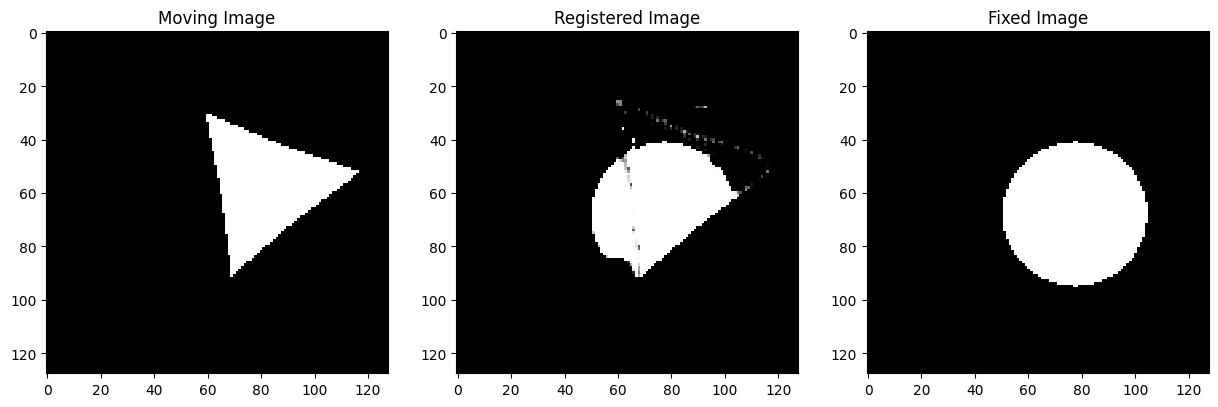

In [25]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[45].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[45].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[45].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

Text(0.5, 1.0, 'Moving Image')

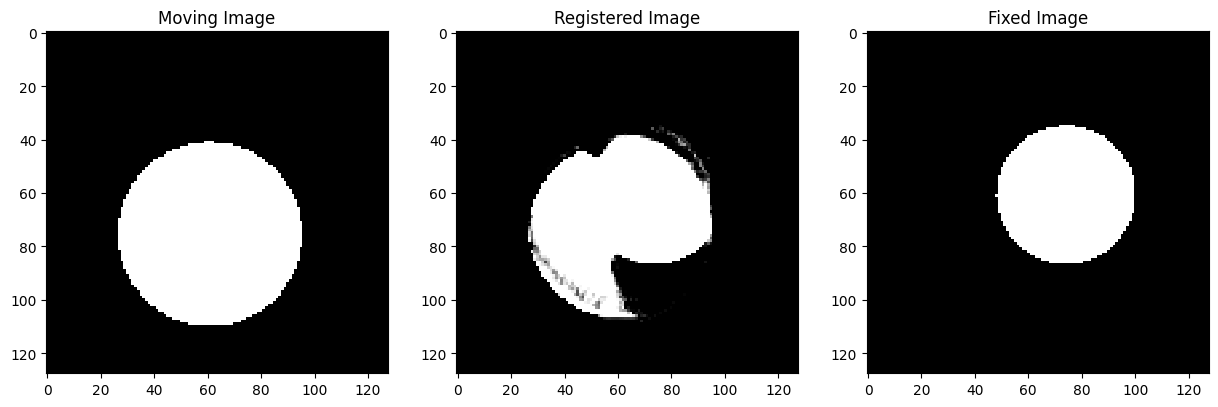

In [26]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[131].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[131].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[131].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

Text(0.5, 1.0, 'Moving Image')

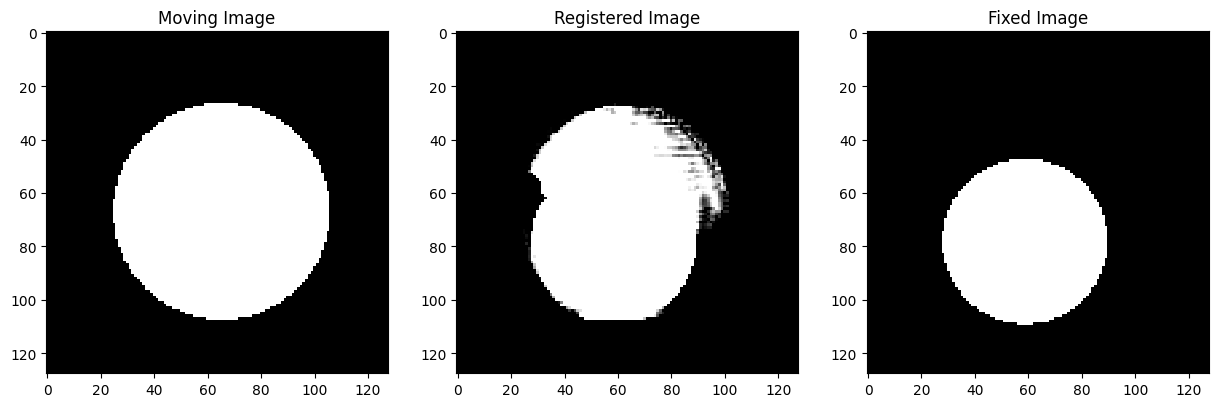

In [27]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[111].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[111].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[111].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

Text(0.5, 1.0, 'Moving Image')

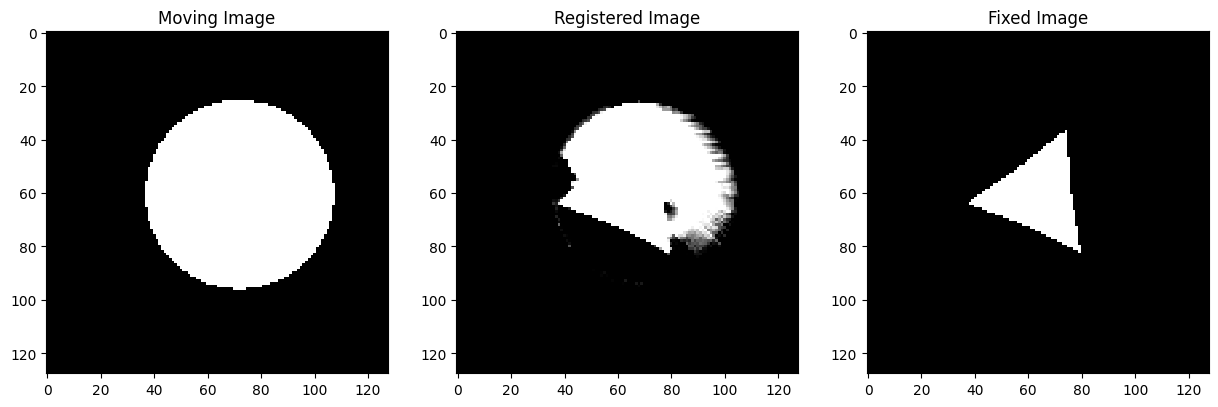

In [28]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[145].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[145].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[145].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

Text(0.5, 1.0, 'Moving Image')

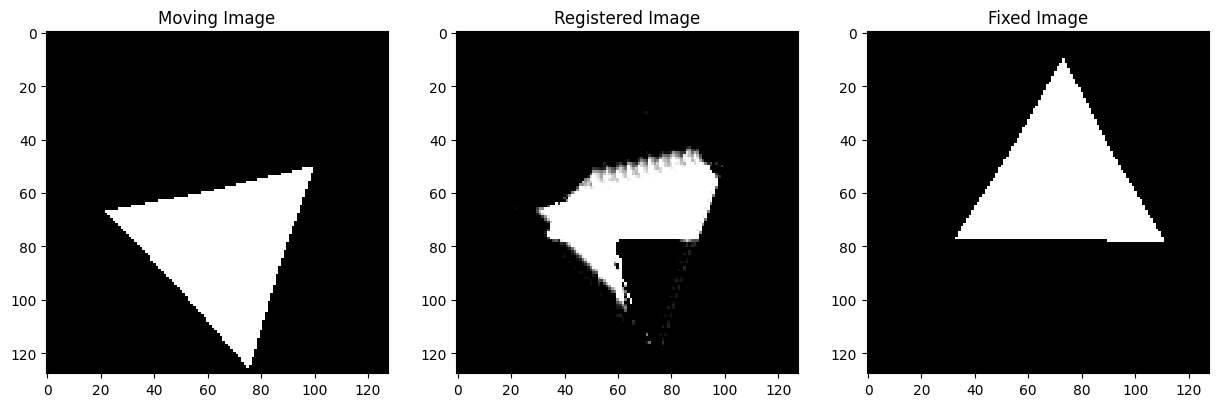

In [30]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[112].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[112].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[112].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

Text(0.5, 1.0, 'Moving Image')

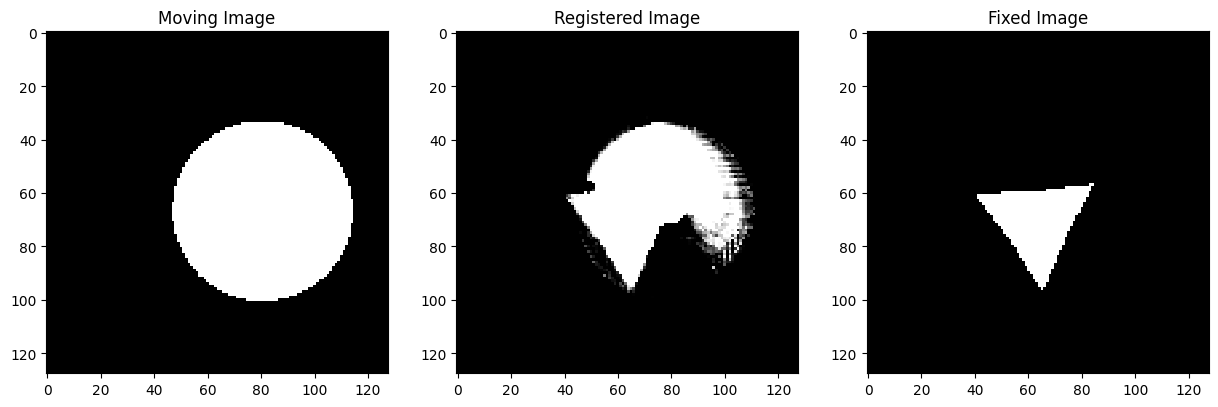

In [31]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[54].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[54].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[54].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

Text(0.5, 1.0, 'Moving Image')

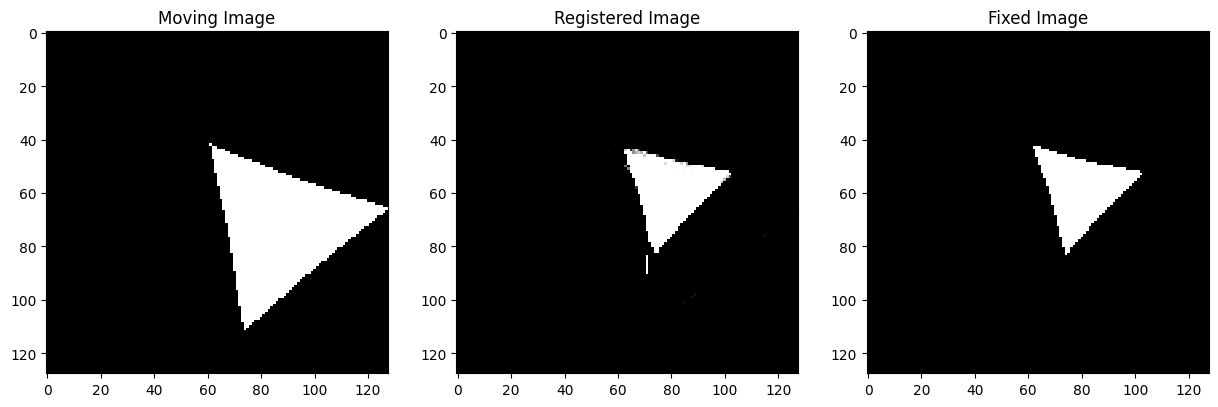

In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[23].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Registered Image")
plt.subplot(1,3,3)
plt.imshow(fixed[23].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image")
plt.subplot(1,3,1)
plt.imshow(moving[23].cpu().data.numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Moving Image")

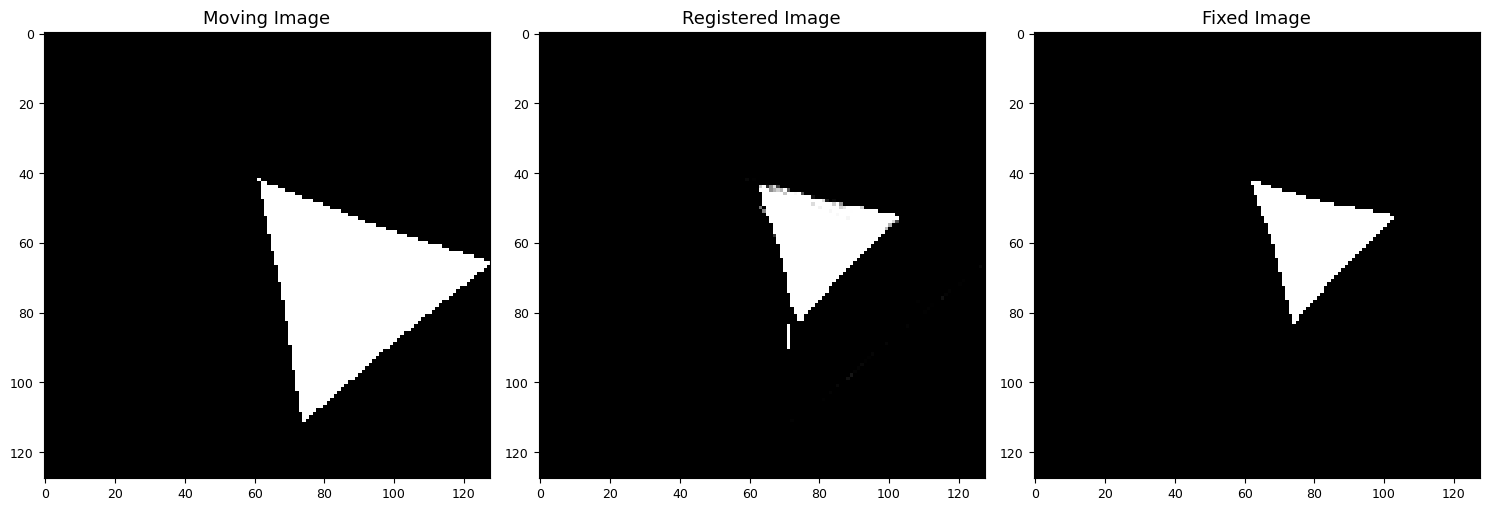

In [41]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[23].cpu().data.numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontsize=13)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.subplot(1,3,3)
plt.imshow(fixed[23].cpu().data.numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Fixed Image", fontsize=13)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.subplot(1,3,1)
plt.imshow(moving[23].cpu().data.numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontsize=13)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()

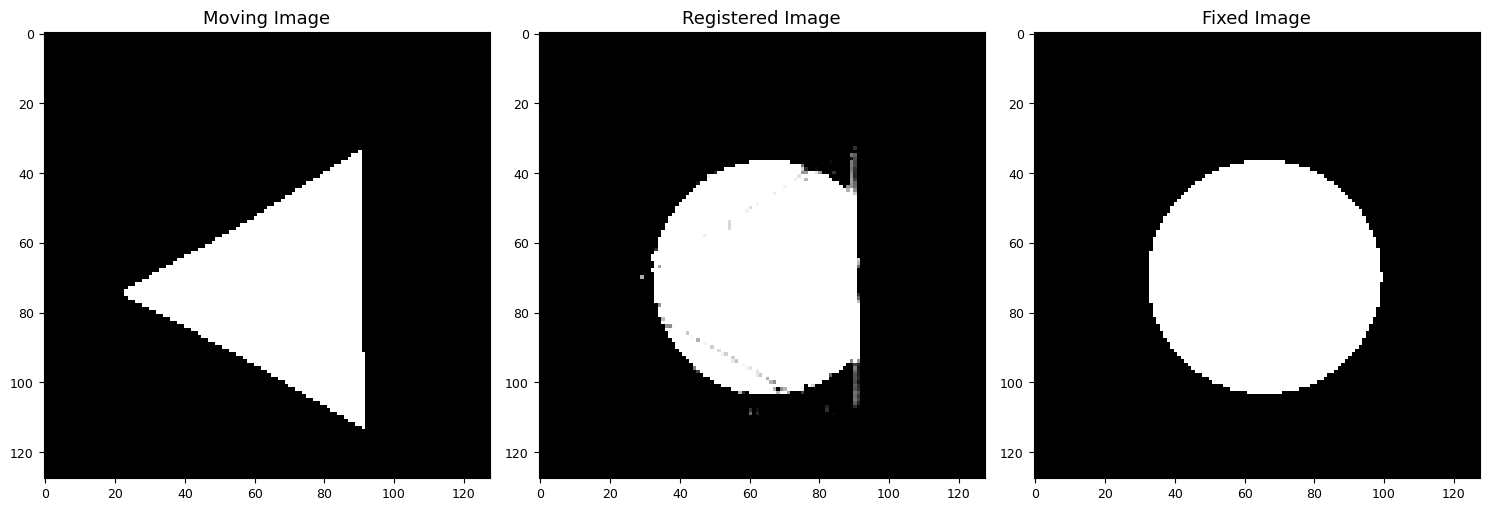

In [44]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[34].cpu().data.numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontsize=13)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.subplot(1,3,3)
plt.imshow(fixed[34].cpu().data.numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Fixed Image", fontsize=13)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.subplot(1,3,1)
plt.imshow(moving[34].cpu().data.numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontsize=13)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()

In [47]:
import neurite as ne

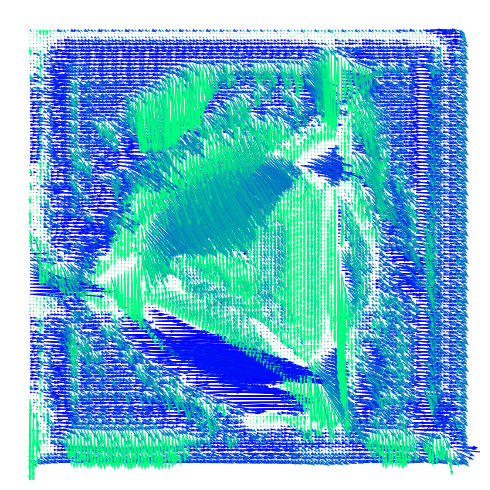

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [49]:
ne.plot.flow([deforms[34].cpu().data.numpy().squeeze()], width = 5)

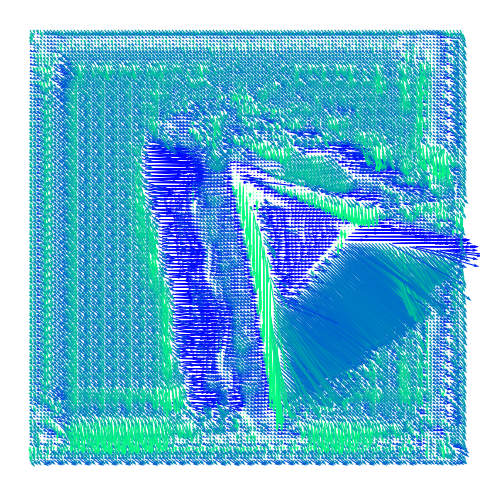

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [50]:
ne.plot.flow([deforms[23].cpu().data.numpy().squeeze()], width = 5)

In [51]:
def dice_score(image1, image2, threshold=True):
    # Convert images to grayscale
    if len(image1.shape) > 2:
        image1 = rgb2gray(image1)
    if len(image2.shape) > 2:
        image2 = rgb2gray(image2)

    # Thresholding (if required)
    if threshold:
        threshold_value1 = threshold_otsu(image1)
        threshold_value2 = threshold_otsu(image2)
        image1 = (image1 > threshold_value1).astype(np.uint8)
        image2 = (image2 > threshold_value2).astype(np.uint8)

    # Calculate Dice score
    intersection = np.sum(image1 & image2)
    union = np.sum(image1) + np.sum(image2)
    dice = (2.0 * intersection) / union
    return dice

In [52]:
def mean_squared_error(image1, image2):
    assert image1.shape == image2.shape, "Images must have the same dimensions"

    mse = np.mean((image1 - image2)**2)
    return mse

In [ ]:
# val_registered[0].cpu().data.numpy().squeeze().shape

(128, 128)

In [ ]:
# validation_fixed[1].cpu().data.numpy().squeeze().shape

(128, 128)

In [53]:
dice_scores = []
mse_scores = []

for idx in range(len(registered)):
    dice = dice_score(registered[idx].cpu().data.numpy().squeeze(), fixed[idx].cpu().data.numpy().squeeze())
    mse = mean_squared_error(registered[idx].cpu().data.numpy().squeeze(), fixed[idx].cpu().data.numpy().squeeze())

    dice_scores.append(dice)
    mse_scores.append(mse)

In [54]:
import pandas as pd
metrics = pd.DataFrame(columns=['dice', 'mse'])

metrics['dice'] = dice_scores
metrics['mse'] = mse_scores

In [55]:
metrics

,dice,mse
0,0.987381,318.235565
1,0.409959,8192.388672
2,0.670271,12045.098633
3,0.499351,7268.795898
4,0.688163,6048.861328
...,...,...
195,0.672354,7833.703613
196,0.456933,3412.593750
197,0.569885,15209.147461
198,0.828249,1134.867432


In [56]:
metrics['dice'].mean()

0.6156244215707963

In [57]:
metrics['mse'].mean()

8788.928

In [ ]:
metrics.to_csv('voxelmorph_gan_triangles_metrics.csv', index=False)

In [ ]:
import os
from torchvision.utils import save_image
from PIL import Image

general_folder = 'voxelmorph_gan_triangles_inference'

if not os.path.exists(general_folder):
    os.makedirs(general_folder)

folder_names = ['fixed', 'moving', 'registered']

for folder_name, tensor_list in zip(folder_names, [validation_fixed, validation_moving, registered]):
    folder_path = os.path.join(general_folder, folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for i, tensor in enumerate(tensor_list):
        image_path = os.path.join(folder_path, f'image_{i}.png')
        numpy_image = tensor.cpu().data.numpy().squeeze()

        numpy_image = numpy_image - np.min(numpy_image)
        numpy_image = numpy_image / np.max(numpy_image)
        pil_image = Image.fromarray((numpy_image * 255).astype(np.uint8))
        pil_image = pil_image.convert('RGB')
        pil_image.save(image_path)

In [ ]:
import pickle

output_file = 'defors_list.pkl'

with open(output_file, 'wb') as f:
    pickle.dump(defors, f)

In [ ]:
!zip -r /content/voxelmorph_gan_triangles_inference.zip /content/voxelmorph_gan_triangles_inference

## INFERENCE FROM LOADED

In [13]:
import neurite as ne

In [14]:
G.load_state_dict(torch.load('/Users/nastya/Documents/ucu/thesis/voxelmorph/triangles/generator.pth', map_location=torch.device('cpu')))
D.load_state_dict(torch.load('/Users/nastya/Documents/ucu/thesis/voxelmorph/triangles/discriminator.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [15]:
def read_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256))
    image = torch.Tensor(image)

    return image

In [ ]:
# validation_moving = [read_image(element[1]) for element in validation_set]
# validation_fixed = [read_image(element[0]) for element in validation_set]

In [16]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

start_time = time.time()

fixed = []
moving = []

registered = []
deforms = []


test_data = TrianglesDataset(test_set)
test_generator = data.DataLoader(test_data, batch_size=1, shuffle=False)

for batch_fixed, batch_moving in tqdm(test_generator):

    fixed.append(batch_fixed)
    moving.append(batch_moving)

    batch_fixed = batch_fixed.unsqueeze(3).to(device)
    batch_moving = batch_moving.unsqueeze(3).to(device)

    val_registered, defor = G(batch_moving, batch_fixed)

    registered.append(val_registered)
    deforms.append(defor)

end_time = time.time() - start_time

print(end_time)

100%|██████████| 200/200 [00:08<00:00, 24.13it/s]

8.303165912628174


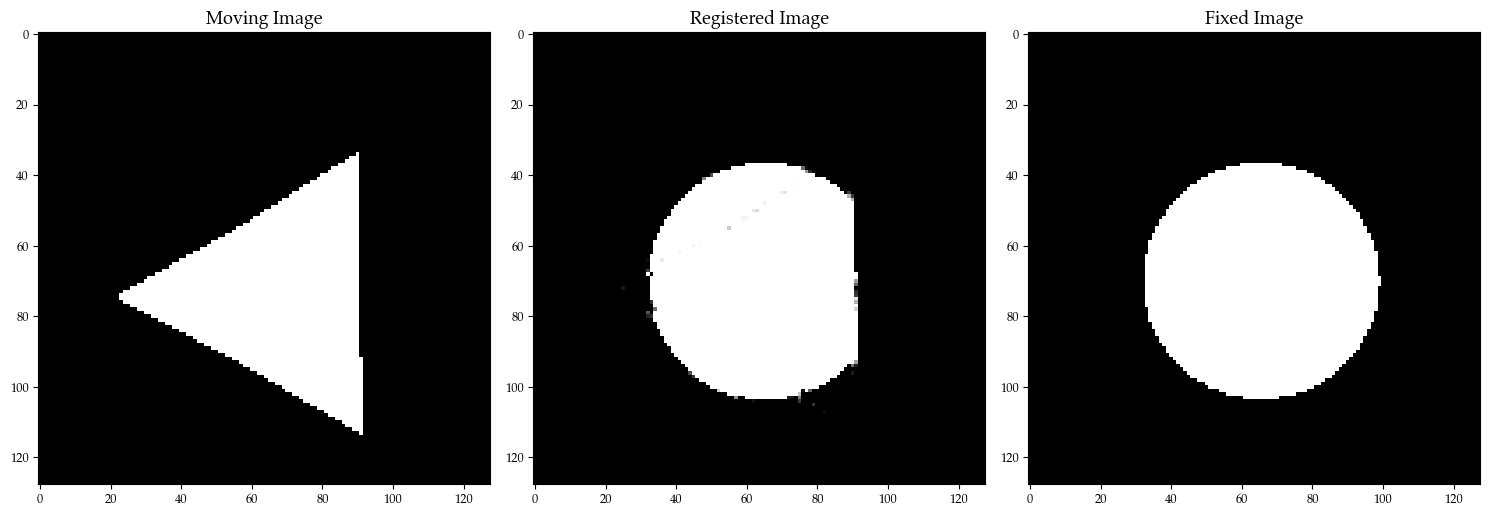

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[34].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,3)
plt.imshow(fixed[34].detach().numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,1)
plt.imshow(moving[34].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontname='Palatino', fontsize=13)

plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.tight_layout()

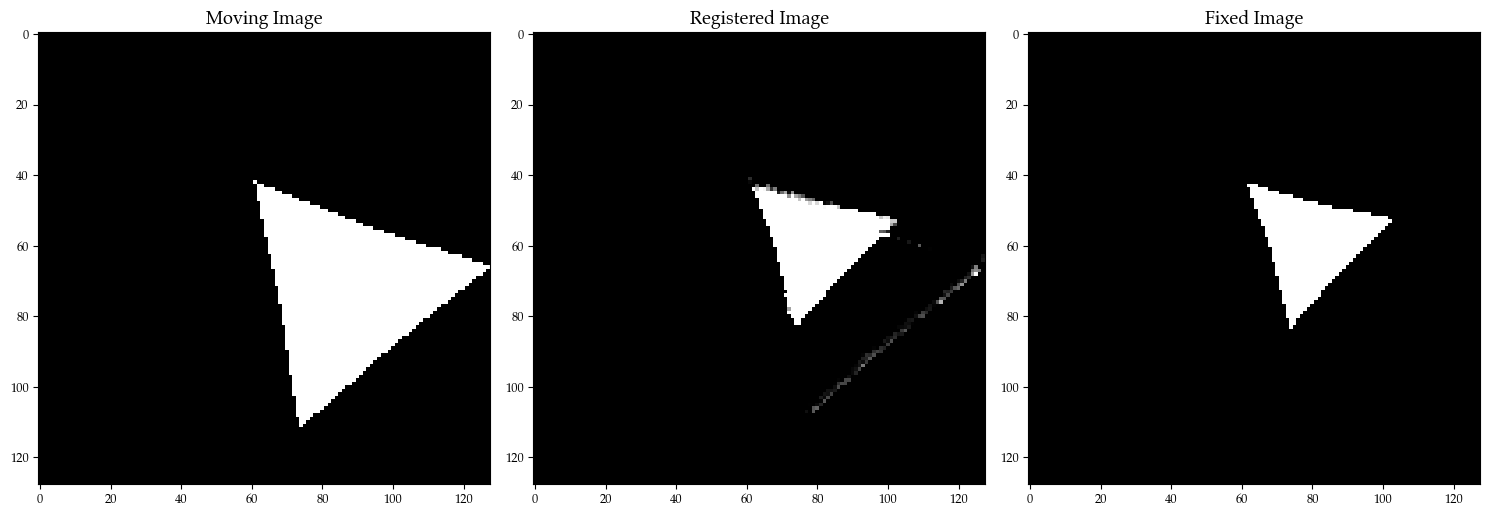

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[23].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,3)
plt.imshow(fixed[23].detach().numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,1)
plt.imshow(moving[23].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontname='Palatino', fontsize=13)

plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.tight_layout()

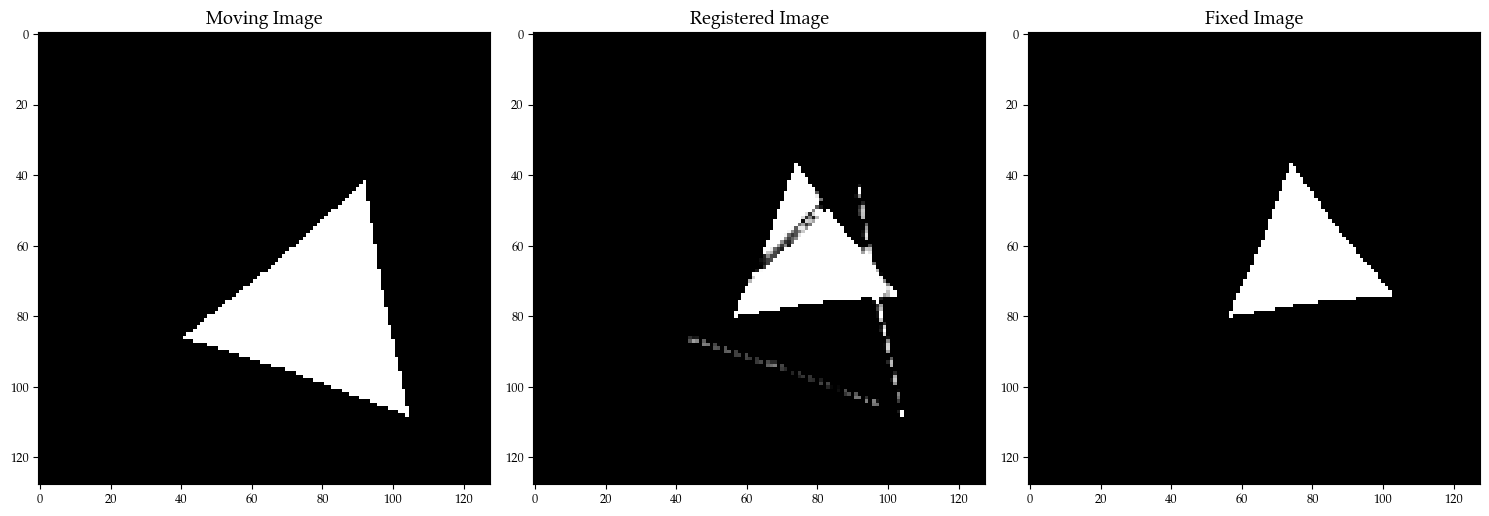

In [61]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[17].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,3)
plt.imshow(fixed[17].detach().numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,1)
plt.imshow(moving[17].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontname='Palatino', fontsize=13)

plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.tight_layout()

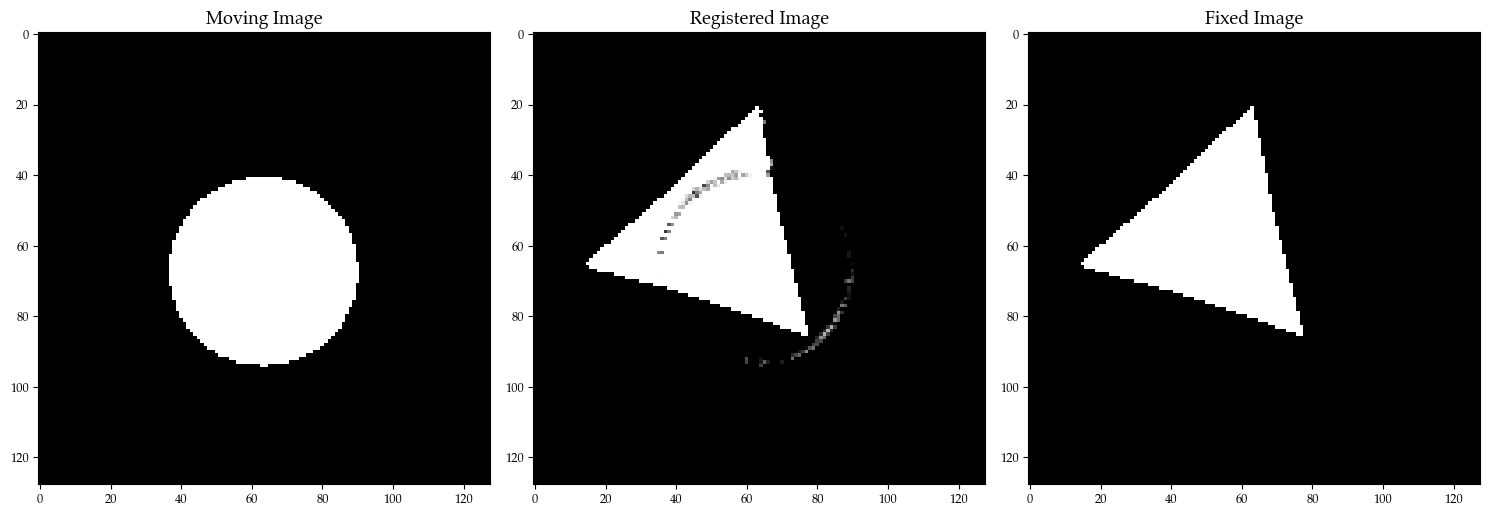

In [70]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[27].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,3)
plt.imshow(fixed[27].detach().numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,1)
plt.imshow(moving[27].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontname='Palatino', fontsize=13)

plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.tight_layout()

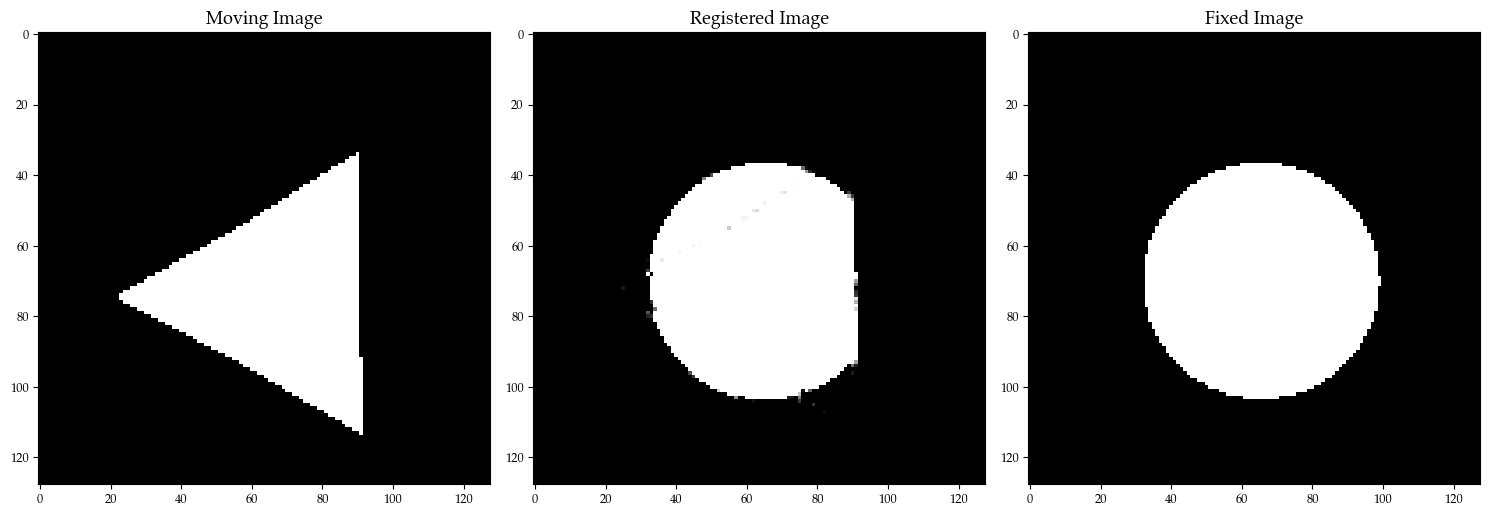

In [77]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[34].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,3)
plt.imshow(fixed[34].detach().numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,1)
plt.imshow(moving[34].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontname='Palatino', fontsize=13)

plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.tight_layout()

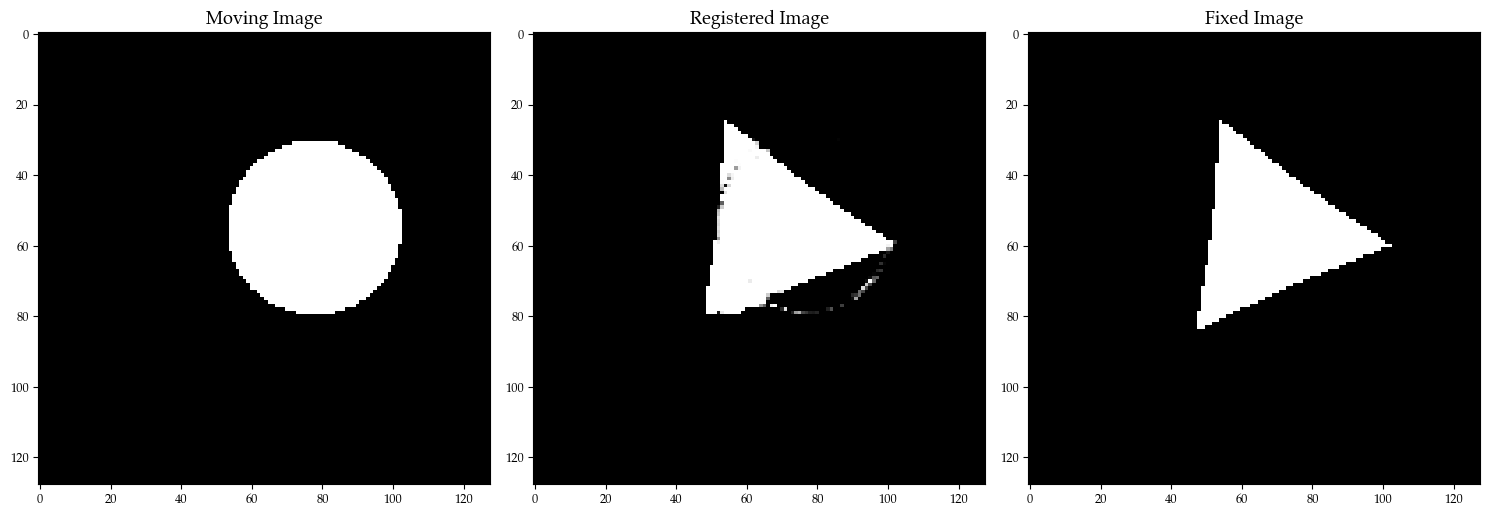

In [92]:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,2)
plt.imshow(registered[48].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Registered Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,3)
plt.imshow(fixed[48].detach().numpy().squeeze(),cmap='gray', interpolation='none')
plt.title("Fixed Image", fontname='Palatino', fontsize=13)
plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.subplot(1,3,1)
plt.imshow(moving[48].detach().numpy().squeeze() ,cmap='gray', interpolation='none')
plt.title("Moving Image", fontname='Palatino', fontsize=13)

plt.xticks(fontname='Palatino', fontsize=9)
plt.yticks(fontname='Palatino', fontsize=9)

plt.tight_layout()

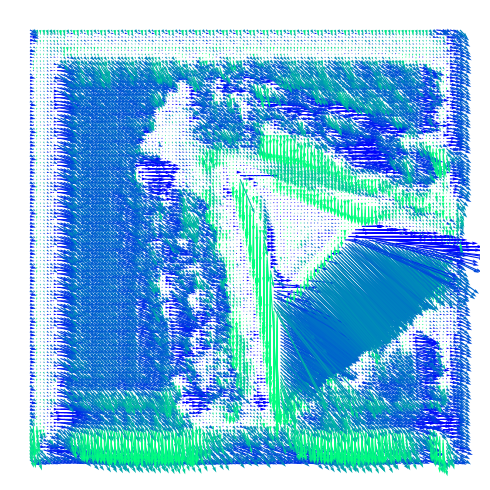

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [21]:
ne.plot.flow([deforms[23].cpu().data.numpy().squeeze()], width = 5)

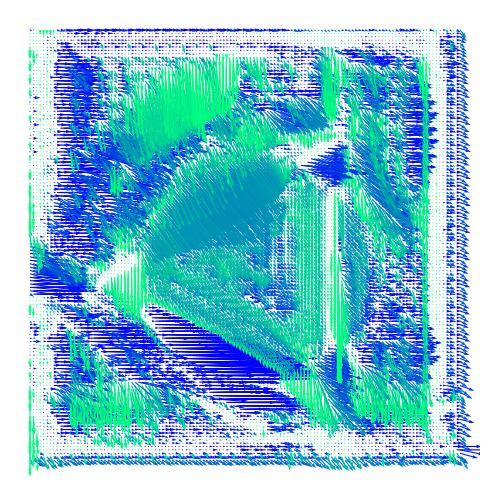

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [23]:
ne.plot.flow([deforms[34].cpu().data.numpy().squeeze()], width = 5)

## METRICS

In [19]:
def dice_score(image1, image2, threshold=True):
    # Convert images to grayscale
    if len(image1.shape) > 2:
        image1 = rgb2gray(image1)
    if len(image2.shape) > 2:
        image2 = rgb2gray(image2)

    # Thresholding (if required)
    if threshold:
        threshold_value1 = threshold_otsu(image1)
        threshold_value2 = threshold_otsu(image2)
        image1 = (image1 > threshold_value1).astype(np.uint8)
        image2 = (image2 > threshold_value2).astype(np.uint8)

    # Calculate Dice score
    intersection = np.sum(image1 & image2)
    union = np.sum(image1) + np.sum(image2)
    dice = (2.0 * intersection) / union
    return dice

In [20]:
def mean_squared_error(image1, image2):
    assert image1.shape == image2.shape, "Images must have the same dimensions"

    mse = np.mean((image1 - image2)**2)
    return mse

In [21]:
dice_scores = []
mse_scores = []

for idx in range(len(registered)):

    registered_float = registered[idx].cpu().data.numpy().squeeze().astype(np.float64) / 255.0
    fixed_float = fixed[idx].cpu().data.numpy().squeeze().astype(np.float64) / 255.0

    dice = dice_score(registered_float, fixed_float)
    mse = mean_squared_error(registered_float, fixed_float)

    dice_scores.append(dice)
    mse_scores.append(mse)

In [22]:
import pandas as pd

metrics_data = pd.DataFrame({
    'dice': dice_scores,
    'mse': mse_scores
})

In [23]:
metrics_data

,dice,mse
0,0.987841,0.004849
1,0.359799,0.154423
2,0.703401,0.168487
3,0.532453,0.102468
4,0.688115,0.092676
...,...,...
195,0.674090,0.124102
196,0.460231,0.052420
197,0.575851,0.229586
198,0.848150,0.015996


In [24]:
metrics_data['mse'].mean()

0.13530520276466096

In [25]:
metrics_data['dice'].mean()

0.6128923873884061

In [29]:
metrics_data.to_csv('/Users/nastya/Documents/ucu/thesis/voxelmorph/vm_gan_triangles/metrics.csv')